In [14]:
import cv2 # computer vision
import numpy as np
import pandas as pd
import os # files 
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

In [60]:
# extraction_path = r"D:\HARenv\human detection and people count\extraction_frames"
extraction_path=r"D:\HARenv\human detection and people count\frames_HAR"

In [61]:
# Path to the video file
# video_path = r"D:\HARenv\multiPeopleHAR.mp4"
# video_path=r"D:\HARenv\HAR_OFFICE.mp4"
video_path=r"D:\HARenv\human detection and people count/har.mp4"
# video_path=r"D:\HARenv\Dataset\sitting\sitting5.mp4"
# Open the video file
cap = cv2.VideoCapture(video_path)

# Get the frames per second (fps) of the video
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define the directory where frames will be saved
# extraction_path = r"D:\HARenv\human detection and people count\extraction_frames"
extraction_path=r"D:\HARenv\human detection and people count\frames_HAR"
# Initialize frame counter
frame_counter = 1

# Loop through the video frames
while True:
    ret, frame = cap.read()

    if not ret:
        break
    
    # Save the frame with a filename like "frame1.jpg" in the specified directory
    frame_filename = os.path.join(extraction_path, f'frame{frame_counter}.jpg')
    cv2.imwrite(frame_filename, frame)
    
    frame_counter += 1

# Release the video capture object
cap.release()

print(f"The frames per second (fps) of the video is: {fps}")

The frames per second (fps) of the video is: 29


In [62]:
print(frame_counter)

681


# (i) Object Detection and Bounding Boxes

# (ii) Counting People

# (iii) Screen Time Calculation


In [9]:
# yolov3 have single output layer for probability distribution and box predictions.
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')
# weights - neural network parameters like bias,propagation etcc.
# cfg - configuration , architecture

In [10]:
# extraction_path=r"D:\HARenv\human detection and people count\extraction_frames"
extraction_path=r"D:\HARenv\human detection and people count\frames_HAR"

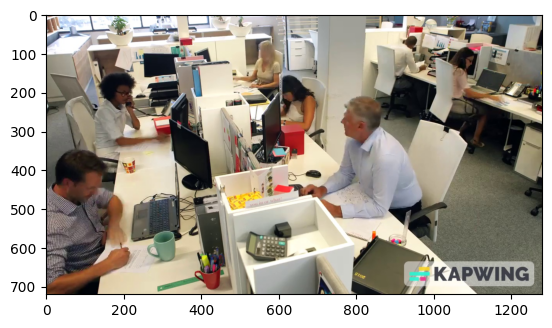

In [32]:
# img = plt.imread(r"D:\HARenv\human detection and people count\extraction_frames\frame20.jpg")   # reading image using its name
# plt.imshow(img)
img = plt.imread(r"D:\HARenv\human detection and people count\frames_HAR\frame20.jpg")   # reading image using its name
plt.imshow(img)

# Human detection

In [63]:
current_person_id = 0
printed_person_ids = set() # to keep track on already printed persons, set is used because of uniqueness
class_ids=[] # 0 for people in the model
data=[] # details of detected persons and their frames

for i in range(1, frame_counter):

    frame_path = extraction_path + "\\frame%d.jpg" % i
    image = cv2.imread(frame_path)
    height, width = image.shape[:2] # first 2 values in the image which is height and width

    # Preprocess the frames for YOLOv3
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
   # A pixel with a value of 0 is completely dark (black), while a pixel with a value of 255 is completely bright (white)
   # 0.00392: This is a scaling factor. It's used to scale pixel values ( adjusting pixel values in a image). In YOLOv3, 
   # images are usually preprocessed by dividing pixel values by 255.0, but this factor helps fine-tune the scaling and normalization
   # open cv loads BGR so swapRB=True
    
    net.setInput(blob) # sets input for the network

    # Get output
    outs = net.forward(net.getUnconnectedOutLayersNames()) # performs forward pass and gets the output.
    # outs =    [x1, y1, width1, height1, confidence1, class_id1]... for all layers 
    # outs - output layer
    
    # Thresholds
    conf_threshold = 0
    nms_threshold = 0

    confidences = []
    boxes = []

    # Detection process
    for out in outs: # iterate each output layer
        for detection in out:  # iterate each detected object in that output layer
            scores = detection[5:] # scores contains the confidence scores for different classes
            class_id = np.argmax(scores) # class_id with the highest confidence
            confidence = scores[class_id] # confidence score for class_id which may person,or object, person's class=0

            if confidence > conf_threshold and class_id == 0:  # checks confidence > threshold class_id = 0 means people
                center_x = int(detection[0] * width) # horizontal center Calculates the x-coordinate of the center of the bounding box in pixels.
                center_y = int(detection[1] * height) #  vertical center Calculates the y-coordinate of the center of the bounding box in pixels.
                w = int(detection[2] * width) # width
                h = int(detection[3] * height) # height
                x = int(center_x - w / 2) # x-coordinate top left corner of bounding box
                y = int(center_y - h / 2) # y-coordinate top left corner of bounding box

                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])

                # class_ids (the class ID, which is 0 for people), confidences (the confidence score),
                # and boxes (the coordinates and dimensions of the bounding box). 
                # This data can be used for further processing or visualization of the detected people

    # Apply Non-Maximum Suppression (NMS)
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    # indices holds the indices of the bounding boxes that represent distinct and confident detections
    current_person_id = 0

    # Draw bounding boxes without tracking
    for index in indices:
        x, y, w, h = boxes[index]
        color = (0, 255, 0)  # Green color
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 3)
        
        # Increment the person ID
        current_person_id += 1 # tracking id

        # Append the data as a dictionary
        data.append({
            "Frame Name": f"frame{i}.jpg",
            "Person ID": current_person_id,
        })

        printed_person_ids.add(current_person_id)

    # Display the frame with bounding boxes
    resized_image = cv2.resize(image, (800, 600))
    cv2.imshow("Bounding box", resized_image)

    key = cv2.waitKey(1)

    if key == ord('q'):
        break

cv2.destroyAllWindows()

In [64]:
print("printed person id ",printed_person_ids)
print("class_id ",class_ids)
print("Data ",data)

printed person id  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
class_id  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Counting people

In [59]:
print("total count of people is ",len(printed_person_ids)) # count total number of ids assigned

total count of people is  5


# Calculate screen time of each person

In [ ]:
# WORST QUALITY
# from pytube import YouTube as yt
# video_link = "https://www.youtube.com/watch?v=9h2bKsJ7j_c"
# vid = yt(video_link)
# stream = vid.streams.first()
# stream.download()

In [ ]:
# df=pd.DataFrame(data)
# df

In [ ]:
# # csv_file = 'data1.csv'

# # # Save the DataFrame to a CSV file
# # df.to_csv(csv_file, index=False)

# data = pd.read_csv('data1.csv')

In [10]:
# first_person = len(data[data['Person ID'] == 1])

# # Count rows where Class is 'Both in the frame'
# p2 = len(data[data['Person ID'] == 2])
# p3 = len(data[data['Person ID'] == 3])
# p4 = len(data[data['Person ID'] == 4])
# p5 = len(data[data['Person ID'] == 5])
# p6 = len(data[data['Person ID'] == 6])
# p7 = len(data[data['Person ID'] == 7])
# p8 = len(data[data['Person ID'] == 8])


# print(f"Count of 'person 1': {first_person} frames ")
# print(f"Count of 'person 2': {p2} frames" )
# print(f"Count of 'person 3': {p3} frames" )
# print(f"Count of 'person 4': {p4} frames" )
# print(f"Count of 'person 5': {p5} frames" )
# print(f"Count of 'person 6': {p6} frames" )
# print(f"Count of 'person 7': {p7} frames" )
# print(f"Count of 'person 8': {p8} frames" )

Count of 'person 1': 240 frames 
Count of 'person 2': 240 frames
Count of 'person 3': 240 frames
Count of 'person 4': 240 frames
Count of 'person 5': 209 frames
Count of 'person 6': 104 frames
Count of 'person 7': 19 frames
Count of 'person 8': 1 frames


In [11]:

# first_person/fps

10.0

Activity recognition

In [9]:
from tensorflow.keras.models import load_model
model = load_model("D:\\HARenv\\HAR_officeActivity")
# model = load_model(r"D:\HARenv\best_model.h5")

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (Batch  (None, 60, 60, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 64)        0         
 D)                                                              
                                                                 
 global_average_pooling2d (  (None, 64)                0         
 GlobalAveragePooling2D)                                         
                                                        

In [11]:
# model = load_model("D:\\HARenv\\HAR_officeActivity")
model_2 = load_model(r"D:\HARenv\best_model.h5")

In [12]:
model_2.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

In [10]:
# from tensorflow.keras.models import load_model

# activity_class_names = ['sitting', 'walking', 'sitting', 'standing', 'typing', 'mobile', 'writing']
# # activity_classes = ['drink', 'mobile', 'sitting', 'standing', 'typing', 'walking', 'writing']

# current_person_id = 0
# printed_person_ids = set()  # to keep track of already printed persons, set is used because of uniqueness
# class_ids = []  # 0 for people in the model
# data = []  # details of detected persons and their frames

# # Load your trained activity recognition model
# model = load_model("D:\\HARenv\\HAR_officeActivity")
# activity_recognition_model = model

# for i in range(1, frame_counter):
#     if i % 10 == 0:
#         frame_path = extraction_path + "\\frame%d.jpg" % i
#         image = cv2.imread(frame_path)
#         height, width = image.shape[:2]

#         # Preprocess the frames for YOLOv3
#         blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
#         # A pixel with a value of 0 is completely dark (black), while a pixel with a value of 255 is completely bright (white)
#    # 0.00392: This is a scaling factor. It's used to scale pixel values ( adjusting pixel values in a image). In YOLOv3, 
#    # images are usually preprocessed by dividing pixel values by 255.0, but this factor helps fine-tune the scaling and normalization
#    # open cv loads BGR so swapRB=True
#         net.setInput(blob) # sets input for the network

#         # Get output
#         outs = net.forward(net.getUnconnectedOutLayersNames())
#         # performs forward pass and gets the output.
#     # outs =    [x1, y1, width1, height1, confidence1, class_id1]... for all layers 
#     # outs - output layer

#         # Thresholds
#         conf_threshold = 0.9  # Increase confidence threshold
#         nms_threshold = 0.3

#         confidences = []
#         boxes = []

#         # Detection process
#         for out in outs:  # iterate each output layer
#             for detection in out: # iterate each detected object in that output layer
#                 scores = detection[5:]# scores contains the confidence scores for different classes
#                 class_id = np.argmax(scores) # class_id with the highest confidence
#                 confidence = scores[class_id]  # confidence score for class_id which may person,or object, person's class=0

#                 if confidence > conf_threshold and class_id == 0:# checks confidence > threshold class_id = 0 means people
#                     center_x = int(detection[0] * width)# horizontal center Calculates the x-coordinate of the center of the bounding box in pixels.
#                     center_y = int(detection[1] * height)#  vertical center Calculates the y-coordinate of the center of the bounding box in pixels.
#                     w = int(detection[2] * width)# width
#                     h = int(detection[3] * height)# height
#                     x = int(center_x - w / 2)# x-coordinate top left corner of bounding box
#                     y = int(center_y - h / 2)# y-coordinate top left corner of bounding box

#                     class_ids.append(class_id)
#                     confidences.append(float(confidence))
#                     boxes.append([x, y, w, h])
#                 # class_ids (the class ID, which is 0 for people), confidences (the confidence score),
#                 # and boxes (the coordinates and dimensions of the bounding box). 
#                 # This data can be used for further processing or visualization of the detected people


#         # Apply Non-Maximum Suppression (NMS)
#         indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

#         current_person_id = 0

#         for index in indices:
#             x, y, w, h = boxes[index]
#             color = (0, 255, 0)  # Green color

#             # Crop the ROI (Region of Interest) based on the bounding box
#             roi = image[y:y + h, x:x + w]

#             current_person_id += 1  # Tracking id

#             try:
#                 # Resize the ROI
#                 roi = cv2.resize(roi, (64, 64))
#                 roi = roi / 255.0  # Normalize to [0, 1]
#             except cv2.error as e:
#                 # Handle the error (empty image) here
#                 print(f"Error resizing ROI: {e}")
#                 continue

#             # Make a prediction using your activity recognition model
#             activity_predictions = activity_recognition_model.predict(np.expand_dims(roi, axis=0))

#             # Get the predicted activity class with the highest probability
#             predicted_activity_class = np.argmax(activity_predictions)

#             # Reduce boundary box thickness and text size
#             box_thickness = 1  # Decrease box thickness
#             text_scale = 0.5  # Decrease text size

#             # Draw the bounding box
#             cv2.rectangle(image, (x, y), (x + w, y + h), color, box_thickness)

#             # Define text settings
#             activity_class = activity_class_names[predicted_activity_class]  # Get the activity class
#             text = f"Person {current_person_id}, Activity: {activity_class}"

#             font = cv2.FONT_HERSHEY_SIMPLEX
#             font_color = (0, 0, 255)  # Red color

#             # Get the size of the text
#             (text_width, text_height), _ = cv2.getTextSize(text, font, text_scale, box_thickness)

#             # Calculate the position for the text to be centered in the bounding box
#             text_x = x + (w - text_width) // 2
#             text_y = y - 5  # Slightly above the top of the bounding box

#             # Display the text with the specified settings
#             cv2.putText(image, text, (text_x, text_y), font, text_scale, font_color, box_thickness)

#             # Append the data as a dictionary
#             data.append({
#                 "Frame Name": f"frame{i}.jpg",
#                 "Person ID": current_person_id,
#                 "Predicted Activity Class": activity_class,  # Include the activity class in the data
#             })

#         # Display the frame with bounding boxes
#         resized_image = cv2.resize(image, (800, 600))
#         cv2.imshow("Bounding box", resized_image)

#         key = cv2.waitKey(100)
#         if key == ord('q'):
#             break
            
# cv2.destroyAllWindows()

1/1 [==============================] - 0s 21ms/step
Error resizing ROI: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

1/1 [==============================] - 0s 20ms/step
Error resizing ROI: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

1/1 [==============================] - 0s 20ms/step
Error resizing ROI: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

1/1 [==============================] - 0s 20ms/step
Error resizing ROI: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

1/1 [==============================] - 0s 19ms/step


In [11]:
model = load_model("D:\\HARenv\\HAR_officeActivity")
# model_2 = load_model(r"D:\HARenv\best_model.h5")

In [13]:
# activity_class_names = ['sitting', 'walking', 'sitting', 'standing', 'typing', 'mobile', 'writing']
# # activity_classes = ['drink', 'mobile', 'sitting', 'standing', 'typing', 'walking', 'writing']

# current_person_id = 0
# printed_person_ids = set()  # to keep track of already printed persons, set is used because of uniqueness
# class_ids = []  # 0 for people in the model
# data = []  # details of detected persons and their frames

# # Load your trained activity recognition model
# model = load_model("D:\\HARenv\\HAR_officeActivity")
# activity_recognition_model = model

# for i in range(1, frame_counter):
#     if i % 10 == 0:
#         frame_path = extraction_path + "\\frame%d.jpg" % i
#         image = cv2.imread(frame_path)
#         height, width = image.shape[:2]

#         # Preprocess the frames for YOLOv3
#         blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
#         net.setInput(blob)

#         # Get output
#         outs = net.forward(net.getUnconnectedOutLayersNames())

#         # Thresholds
#         conf_threshold = 0.9  # Increase confidence threshold
#         nms_threshold = 0.3

#         confidences = []
#         boxes = []

#         # Detection process
#         for out in outs:
#             for detection in out:
#                 scores = detection[5:]
#                 class_id = np.argmax(scores)
#                 confidence = scores[class_id]

#                 if confidence > conf_threshold and class_id == 0:
#                     center_x = int(detection[0] * width)
#                     center_y = int(detection[1] * height)
#                     w = int(detection[2] * width)
#                     h = int(detection[3] * height)
#                     x = int(center_x - w / 2)
#                     y = int(center_y - h / 2)

#                     class_ids.append(class_id)
#                     confidences.append(float(confidence))
#                     boxes.append([x, y, w, h])

#         # Apply Non-Maximum Suppression (NMS)
#         indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

#         current_person_id = 0

#         for index in indices:
#             x, y, w, h = boxes[index]
#             color = (0, 255, 0)  # Green color

#             # Crop the ROI (Region of Interest) based on the bounding box
#             roi = image[y:y + h, x:x + w]

#             current_person_id += 1  # Tracking id

#             try:
#                 # Resize the ROI
#                 roi = cv2.resize(roi, (64, 64))
#                 roi = roi / 255.0  # Normalize to [0, 1]
#             except cv2.error as e:
#                 # Handle the error (empty image) here
#                 print(f"Error resizing ROI: {e}")
#                 continue

#             # Make a prediction using your activity recognition model
#             activity_predictions = activity_recognition_model.predict(np.expand_dims(roi, axis=0))

#             # Get the predicted activity class with the highest probability
#             predicted_activity_class = np.argmax(activity_predictions)

#             # Reduce boundary box thickness and text size
#             box_thickness = 1  # Decrease box thickness
#             text_scale = 0.5  # Decrease text size

#             # Draw the bounding box
#             cv2.rectangle(image, (x, y), (x + w, y + h), color, box_thickness)

#             # Define text settings
#             activity_class = activity_class_names[predicted_activity_class]  # Get the activity class
#             text = f"Person {current_person_id}, Activity: {activity_class}"

#             font = cv2.FONT_HERSHEY_SIMPLEX
#             font_color = (0, 0, 255)  # Red color

#             # Get the size of the text
#             (text_width, text_height), _ = cv2.getTextSize(text, font, text_scale, box_thickness)

#             # Calculate the position for the text to be centered in the bounding box
#             text_x = x + (w - text_width) // 2
#             text_y = y - 5  # Slightly above the top of the bounding box

#             # Display the text with the specified settings
#             cv2.putText(image, text, (text_x, text_y), font, text_scale, font_color, box_thickness)

#             # Append the data as a dictionary
#             data.append({
#                 "Frame Name": f"frame{i}.jpg",
#                 "Person ID": current_person_id,
#                 "Predicted Activity Class": activity_class,  # Include the activity class in the data
#             })

#         # Display the frame with bounding boxes
#         resized_image = cv2.resize(image, (800, 600))
#         cv2.imshow("Bounding box", resized_image)

#         key = cv2.waitKey(100)
#         if key == ord('q'):
#             break
            
# cv2.destroyAllWindows()

1/1 [==============================] - 0s 63ms/step
Error resizing ROI: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

1/1 [==============================] - 0s 69ms/step
Error resizing ROI: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

1/1 [==============================] - 0s 63ms/step
Error resizing ROI: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

1/1 [==============================] - 0s 66ms/step
Error resizing ROI: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

1/1 [==============================] - 0s 63ms/step


In [10]:
# printed_person_ids = set()  # to keep track of already printed persons, set is used because of uniqueness
# class_ids = []  # 0 for people in the model
# data = []  # details of detected persons and their frames
# target_words = ["sitting", "walking", "standing", "writing"]
# for i in range(1, frame_counter):

#     frame_path = extraction_path + "\\frame%d.jpg" % i
#     image = cv2.imread(frame_path)
#     height, width = image.shape[:2]  # first 2 values in the image which are height and width

#     # Preprocess the frames for YOLOv3
#     blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
#     net.setInput(blob)  # sets input for the network

#     # Get output
#     outs = net.forward(net.getUnconnectedOutLayersNames())  # performs forward pass and gets the output.

#     # Thresholds
#     conf_threshold = 0.8
#     nms_threshold = 0

#     confidences = []
#     boxes = []

#     # Detection process
#     for out in outs:  # iterate each output layer
#         for detection in out:  # iterate each detected object in that output layer
#             scores = detection[5:]  # scores contain the confidence scores for different classes
#             class_id = np.argmax(scores)  # class_id with the highest confidence
#             confidence = scores[class_id]  # confidence score for class_id which may be person (person's class_id = 0)

#             if confidence > conf_threshold and class_id == 0:  # check if confidence > threshold and class_id is 0 (people)
#                 center_x = int(detection[0] * width)  # horizontal center
#                 center_y = int(detection[1] * height)  # vertical center
#                 w = int(detection[2] * width)  # width
#                 h = int(detection[3] * height)  # height
#                 x = int(center_x - w / 2)  # x-coordinate top left corner of bounding box
#                 y = int(center_y - h / 2)  # y-coordinate top left corner of bounding box

#                 class_ids.append(class_id)
#                 confidences.append(float(confidence))
#                 boxes.append([x, y, w, h])

#     # Apply Non-Maximum Suppression (NMS)
#     indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

#     # Draw bounding boxes without tracking
#     current_person_id = 0

#     for index in indices:
#         x, y, w, h = boxes[index]

#         # Crop the detected person from the frame
#         cropped_person = image[y:y + h, x:x + w]
#         current_person_id += 1
#         try:  
#             # Pass the cropped image to your caption generation model
#             raw_image = Image.fromarray(cv2.cvtColor(cropped_person, cv2.COLOR_BGR2RGB))
#         except cv2.error as e:
            
#             # Handle the error (empty image) here
#             print(f"Error resizing ROI: {e}")
#             continue
            
#         inputs = processor(raw_image, return_tensors="pt")
#         out = model.generate(**inputs)
#         caption = processor.decode(out[0], skip_special_tokens=True)
#         detected_action = None

#         # Search for target words in the generated caption
#         for word in target_words:
#             if word in caption:
#                 detected_action = word
#                 break  # Stop searching once a target word is found
        
#         # Print the detected action
#         if detected_action:
#             print(f"Frame {i} - Person {current_person_id} is {detected_action}")
#         else:
#             print(f"Frame {i} - Person {current_person_id} - No specific action detected")

#         # Print the caption for the person
#         # print(f"Frame {i} - Person {current_person_id} is {caption}")
        
#         # Display the cropped person with bounding box
#         cv2.imshow("Cropped Person", cropped_person)

#         key = cv2.waitKey(1)
    
#         if key == ord('q'):
#             break

# # Close all OpenCV windows
# cv2.destroyAllWindows()


In [19]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

In [66]:
# Initialize variables and lists
printed_person_ids = set()
class_ids = []
data = []  # List to store frame, person ID, and action
target_words = ["sitting", "walking", "standing", "writing",'talking','mobile','typing','computer','chatting','leaning']
window_name = "Cropped Person"  # Define the window name

# Create a window and set its properties (you can adjust the size as needed)
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
cv2.resizeWindow(window_name, 400, 400)

for i in range(1, frame_counter):
    if i % 1 != 0:
        continue  # Skip frames that are not divisible by 10

    frame_path = extraction_path + "\\frame%d.jpg" % i
    image = cv2.imread(frame_path)
    height, width = image.shape[:2]

    # Preprocess the frames for YOLOv3
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    # Get output
    outs = net.forward(net.getUnconnectedOutLayersNames())

    # Thresholds
    conf_threshold = 0
    nms_threshold = 0

    confidences = []
    boxes = []

    # Detection process
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > conf_threshold and class_id == 0:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])

    # Apply Non-Maximum Suppression (NMS)
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    # Draw bounding boxes without tracking
    current_person_id = 0

    for index in indices:
        x, y, w, h = boxes[index]

        # Crop the detected person from the frame
        cropped_person = image[y:y + h, x:x + w]
        current_person_id += 1
        detected_action = None

        try:
            # Pass the cropped image to your caption generation model
            raw_image = cv2.resize(cropped_person, (800, 600))  # Resize the image for better display
            inputs = processor(Image.fromarray(cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)), return_tensors="pt")
            out = model.generate(**inputs)
            caption = processor.decode(out[0], skip_special_tokens=True)

            # # Search for target words in the generated caption
            # for word in target_words:
            #     if word in caption:
            #         detected_action = word
            #         break  # Stop searching once a target word is found

        except cv2.error as e:
            # Handle the error (empty image) here
            print(f"Error resizing ROI: {e}")

        # Store the frame, person ID, and detected action in the list
        # data.append([i, current_person_id, detected_action])
        data.append([i, current_person_id, caption])

        # Print the detected action
        # if detected_action:
        print(f"Frame {i} - Person {current_person_id} is {caption}")
        # else:
            # print(f"Frame {i} - Person {current_person_id} - No specific action detected")

        # Display the cropped person with bounding box
        try:
            cv2.imshow(window_name, raw_image)
        except cv2.error as e:
            # Handle the "size.width>0 && size.height>0" error with an exception
            print(f"Error displaying image: {e}")

        key = cv2.waitKey(1)

        if key == ord('q'):
            break

# Close the OpenCV window
cv2.destroyWindow(window_name)

# Create a dataframe from the collected data
df = pd.DataFrame(data, columns=["Frame", "Person ID", "Detected Action"])

Frame 1 - Person 1 is there is a man in a suit and tie standing next to a suitcase
Frame 1 - Person 2 is there is a man in a suit leaning over a desk
Frame 1 - Person 3 is woman in red shirt riding a skateboard on a sidewalk
Frame 1 - Person 4 is woman in black dress holding a yellow folder in an airport
Frame 1 - Person 5 is blurry image of a man sitting on a bench in a public area
Frame 1 - Person 6 is there is a man in a black jacket and a backpack on a bus
Frame 1 - Person 7 is there are two women sitting on a chair talking to each other
Frame 1 - Person 8 is there is a white bed with a white sheet and a black vase
Frame 1 - Person 9 is blurry photo of a white truck with a red tail light
Frame 1 - Person 10 is a woman sitting on a chair in a room with a table
Frame 2 - Person 1 is arafed man in a suit and tie standing next to a green suitcase
Frame 2 - Person 2 is there is a man in a suit leaning over a desk
Frame 2 - Person 3 is there is a woman sitting on a chair with a dog
Frame

KeyboardInterrupt: 

In [67]:
df

NameError: name 'df' is not defined

In [11]:
df.to_csv('HAR_and_detection.csv', index=False)

In [12]:
data = pd.read_csv('HAR_and_detection.csv')

In [13]:
data

,Frame,Person ID,Detected Action
0,1,1,woman sitting on a couch talking on a cell phone
1,1,2,there is a man that is looking at his cell phone
2,1,3,woman in black dress holding a tray of food in...
3,1,4,there are two people walking down the street w...
4,2,1,woman sitting on a couch talking on a cell phone
...,...,...,...
1309,269,1,woman sitting on a bench talking on a cell phone
1310,269,2,araffe walking in a hallway with a suitcase an...
1311,269,3,there is a man that is looking at his cell phone
1312,269,4,woman in black dress holding a plaque while st...


In [15]:
target_words = ["sitting", "walking", "standing", "writing", 'talking', 'mobile']

# Initialize a dictionary to store the counts for each person and action
person_action_counts = {}

# Loop through each row in the DataFrame
for index, row in df.iterrows():
    frame = row["Frame"]
    person_id = row["Person ID"]
    detected_action = row["Detected Action"].lower()  # Convert to lowercase for case-insensitive matching
    
    # Initialize counts for the current person if not already done
    if person_id not in person_action_counts:
        person_action_counts[person_id] = {action: 0 for action in target_words}
    
    # Check if any of the target words/actions are present in the detected action
    for action in target_words:
        if action in detected_action:
            person_action_counts[person_id][action] += 1

# Print the results
for person_id, actions in person_action_counts.items():
    print(f"Person {person_id} actions:")
    for action, count in actions.items():
        print(f"{action}: {count} frames")
    print()

Person 1 actions:
sitting: 133 frames
walking: 106 frames
standing: 3 frames
writing: 0 frames
talking: 137 frames
mobile: 0 frames

Person 2 actions:
sitting: 123 frames
walking: 65 frames
standing: 6 frames
writing: 0 frames
talking: 132 frames
mobile: 0 frames

Person 3 actions:
sitting: 23 frames
walking: 44 frames
standing: 103 frames
writing: 0 frames
talking: 31 frames
mobile: 0 frames

Person 4 actions:
sitting: 14 frames
walking: 67 frames
standing: 76 frames
writing: 0 frames
talking: 21 frames
mobile: 0 frames

Person 5 actions:
sitting: 30 frames
walking: 106 frames
standing: 24 frames
writing: 0 frames
talking: 53 frames
mobile: 0 frames

Person 6 actions:
sitting: 0 frames
walking: 0 frames
standing: 1 frames
writing: 0 frames
talking: 0 frames
mobile: 0 frames

